In [1]:
#This module predicts stock closing prices using an artificial neural network called Long Short Memory (LSTM)
#it will use the prices of the last 60 days
#for the purpose of this module APPLE Inc. will be used as an example, but the module should
#be flexible to adapt to any (listed) company

In [3]:
#import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [26]:
pip install yfinance


In [1]:
import yfinance as yf
aapl = yf.Ticker("AMZN")
df = aapl.history(start="2012-01-01", end="2024-03-21")

df

ModuleNotFoundError: No module named 'yfinance'

In [37]:
#Get the number of rows and columns in the dataset
df.shape

(3073, 7)

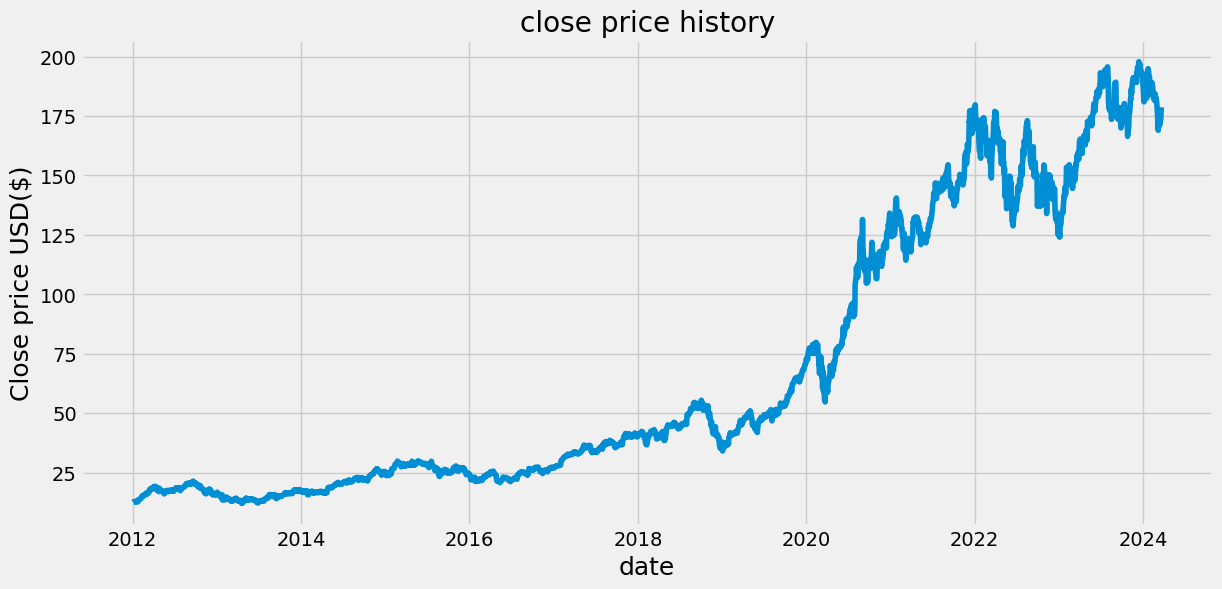

In [40]:
#Visualize closing price history
plt.figure(figsize=(13,6))
plt.title('close price history')
plt.plot(df['Close'])
plt.xlabel('date', fontsize = 18)
plt.ylabel('Close price USD($)', fontsize=18)
plt.show()

In [42]:
#create a new dataframe with only the close column

data = df.filter(['Close'])

#convert the dataframe to a numpy array

dataset = data.values

#get the number of rows to train the model on

training_data_len = math.ceil(len(dataset) *0.8)

training_data_len

2459

In [43]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00242954],
       [0.00278903],
       [0.00353568],
       ...,
       [0.87014128],
       [0.88283797],
       [0.89677202]])

In [47]:
#create the training dataset
#create the scaled training data set

train_data = scaled_data[0:training_data_len, :]

#split the data into x_train and y_train data sets

x_train= []
y_train= []

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60: i,0])
  y_train.append(train_data[i,0])
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.00242954, 0.00278903, 0.00353568, 0.00424653, 0.00413754,
       0.00438316, 0.00427093, 0.00408223, 0.00382521, 0.00462067,
       0.00533802, 0.00511678, 0.00390493, 0.00506148, 0.00392283,
       0.00819283, 0.00786261, 0.00829367, 0.00922577, 0.00979021,
       0.00974303, 0.00956898, 0.01031074, 0.01100855, 0.01179912,
       0.01307607, 0.01575844, 0.01579911, 0.01729243, 0.01840831,
       0.01649046, 0.01722896, 0.01721428, 0.01928509, 0.01899058,
       0.01953554, 0.02051479, 0.02105976, 0.02262951, 0.02377301,
       0.02410324, 0.02421874, 0.02226351, 0.02179176, 0.02186168,
       0.02369985, 0.02421708, 0.02532815, 0.02794706, 0.0314411 ,
       0.03078719, 0.03078884, 0.03331503, 0.03410561, 0.03354278,
       0.03302875, 0.03249362, 0.03427152, 0.03549153, 0.0360023 ])]
[0.03474000024237528]

[array([0.00242954, 0.00278903, 0.00353568, 0.00424653, 0.00413754,
       0.00438316, 0.00427093, 0.00408223, 0.00382521, 0.00462067,
       0.00533802, 0.00511678, 0.00

In [48]:
#convert the x_train and y_train into numpy arrays

x_train, y_train = np.array(x_train), np.array(y_train)

In [50]:
#reshape the data

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2399, 60, 1)

In [52]:
#build the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape= (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [53]:
#Compile the model

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [54]:
#Train the model

model.fit(x_train, y_train, batch_size = 1, epochs= 1)

2399/2399 [==============================] - 83s 33ms/step - loss: 6.6346e-04


In [55]:
#Create the testing data set
#Create an array containing scaled values from index 2399 to 2459

test_data = scaled_data[training_data_len - 60 : , :]

#Create the data sets x_test and y_test

x_test = []
y_test = dataset[training_data_len : , :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [56]:
#Convert the data to a numpy array

x_test = np.array(x_test)

In [57]:
#reshape the data

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [59]:
#get the models predicted price values for x_test

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

20/20 [==============================] - 0s 23ms/step


In [62]:
#Get the root mean squared error (RMSE) --> the lower the value, the more accurate the model

rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

9.869812247807506

<ipython-input-66-d017a51124d6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


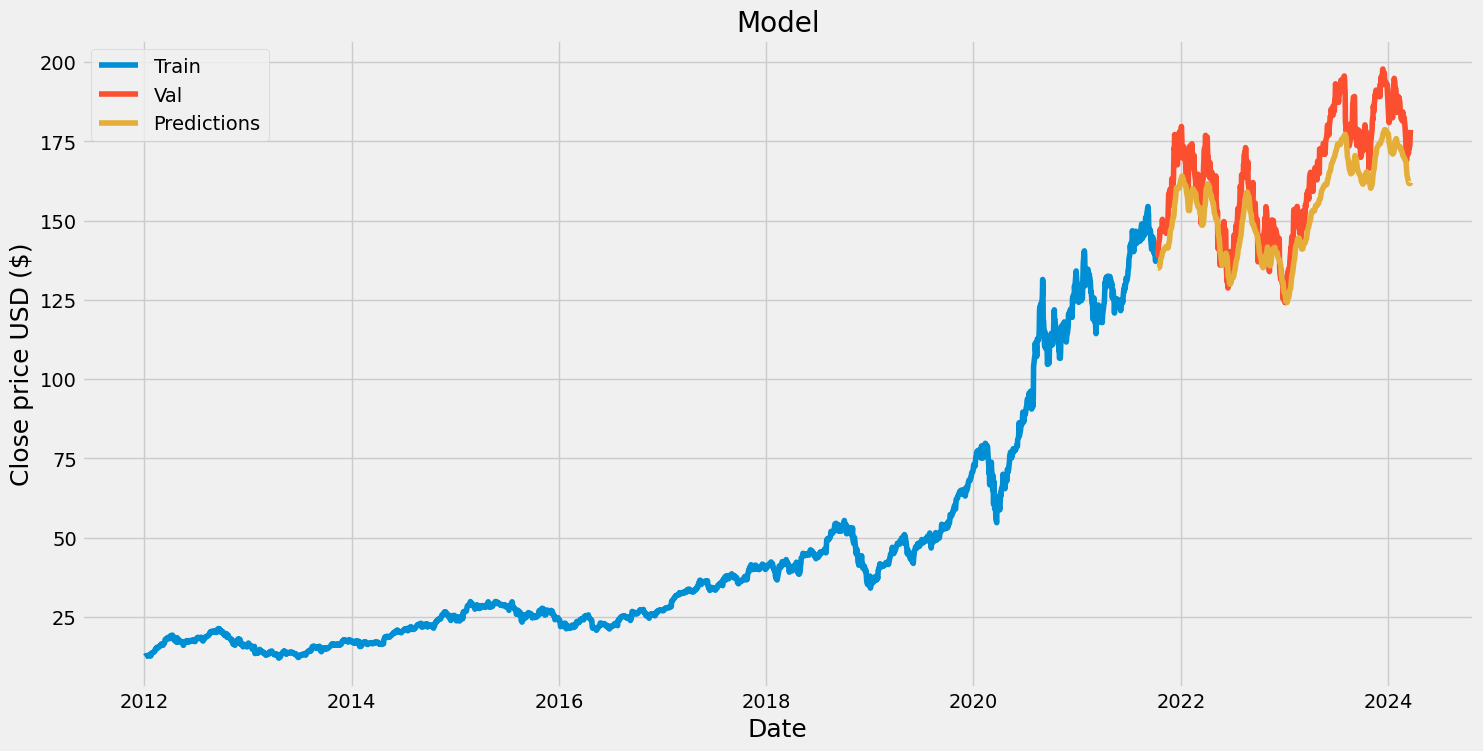

In [66]:
#Plot the data

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#visualize the data

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close price USD ($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'upper left')
plt.show()

In [67]:
#Show the valid and predicted prices

valid

,Close,Predictions
Date,,
2021-10-11 00:00:00-04:00,140.811295,135.251251
2021-10-12 00:00:00-04:00,139.529480,135.281174
2021-10-13 00:00:00-04:00,138.937881,135.229446
2021-10-14 00:00:00-04:00,141.747955,135.091034
2021-10-15 00:00:00-04:00,142.812851,135.133347
...,...,...
2024-03-14 00:00:00-04:00,173.000000,161.924377
2024-03-15 00:00:00-04:00,172.619995,161.779175
2024-03-18 00:00:00-04:00,173.720001,161.710953


In [68]:
import pandas_datareader as web

In [80]:
#get the quote

import yfinance as yf
aapl = yf.Ticker("AAPL")
apple_quote = aapl.history(start="2012-01-01", end="2024-03-21")

#Create a new dataframe

new_df = apple_quote.filter(['Close'])

#Get the last 60 days closing price values and convert the df to an array

last_60_days = new_df[-60:].values

#Scale the data to be between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

#Create an empty list

X_test = []

#Append the last 60 days to the empty list

X_test.append(last_60_days_scaled)
#Convert the X_test dataset to a numpy array

X_test = np.array(X_test)
#Reshape the dataset

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Get the predicted scaled price

pred_price = model.predict(X_test)

#undo the scaling

pred_price = scaler.inverse_transform(pred_price)

print(pred_price)


1/1 [==============================] - 0s 43ms/step
[[162.61688]]


In [82]:
import yfinance as yf
aapl = yf.Ticker("AAPL")
apple_quote_2= aapl.history(start="2024-03-21", end="2024-03-21")
print(apple_quote_2['Close'])

Date
2024-03-20 00:00:00-04:00    178.669998
Name: Close, dtype: float64
